In [1]:
from transformers import RobertaForSequenceClassification
from transformers import RobertaTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm.auto import tqdm
from torch.optim import AdamW
from sklearn.metrics import classification_report
from accelerate import Accelerator
import tensorflow as tf
import numpy as np
import sentencepiece
from datasets import load_dataset
import random as ra
import torch.nn as nn
import gensim.downloader as api
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
data = load_dataset("dair-ai/emotion", download_mode="force_redownload")
print(f"Train dataset size: {len(data['train'])}")
print(f"Test dataset size: {len(data['test'])}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train dataset size: 16000
Test dataset size: 2000


In [3]:
# check
data


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Modeling


## 1. RoBERTa (by Kexin)

### Load model and tokenizer

In [4]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=6)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model.config.id2label = {    
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"}


In [6]:
model.config.label2id = {
 'sadness': 0,
 'joy': 1,
 'love': 2,
 'anger': 3,
 'fear': 4,
 'surprise': 5}


In [7]:
model.config


RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Note: RoBERTa tokenizer uses **byte-level Byte-Pair-Encoding**.

In [8]:
RoBERTa_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


### Pre-process dataset

In [9]:
# check dataset
data


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
def RoBERTa_tokenize_function(examples):
    return RoBERTa_tokenizer(examples["text"], padding="max_length", truncation=True)


In [11]:
RoBERTa_tokenized_datasets = data.map(RoBERTa_tokenize_function, batched=True)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
# check tokenized dataset

RoBERTa_tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [13]:
RoBERTa_tokenizer.decode(RoBERTa_tokenized_datasets['test']['input_ids'][0],return_tensors='pt')


'<s>im feeling rather rotten so im not very ambitious right now</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [14]:
# Remove the text column because the model does not accept raw text as an input:
RoBERTa_tokenized_datasets = RoBERTa_tokenized_datasets.remove_columns(["text"])
# Rename the label column to labels because the model expects the argument to be named labels:
RoBERTa_tokenized_datasets = RoBERTa_tokenized_datasets.rename_column("label", "labels")
RoBERTa_tokenized_datasets.set_format("torch")


In [15]:
# Then create a smaller subset of the dataset as previously shown to speed up the fine-tuning:
RoBERTa_small_train_dataset = RoBERTa_tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
RoBERTa_small_eval_dataset = RoBERTa_tokenized_datasets["test"].shuffle(seed=42).select(range(1000))


In [16]:
RoBERTa_train_dataloader = DataLoader(RoBERTa_small_train_dataset, shuffle=True, batch_size=16)
RoBERTa_eval_dataloader = DataLoader(RoBERTa_small_eval_dataset, batch_size=8)


### Fine-tune

In [17]:
# the folowing paras are the same as in our reference paper

batch_size = 16
num_epochs = 10
num_training_steps = num_epochs * len(RoBERTa_train_dataloader)
total_steps = len(RoBERTa_train_dataloader) 

optimizer = AdamW(model.parameters(), lr=4e-5) #Adam optimizer with weight decay

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [18]:
device = "cpu" # found if use mps, the traing loss will become nan
model.to(device) 
device


'cpu'

In [19]:
progress_bar = tqdm(range(num_training_steps))

model.train()
total_loss = 0
accelerator = Accelerator()

for epoch in range(num_epochs):
    
    print('-' * 20)
    print(f'Begin epoch {epoch+1}')
    print('-' * 20)
    
    for step, batch in enumerate(RoBERTa_train_dataloader): # 63 + 1
        
        optimizer.zero_grad()       
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch) # equivalent to model.forward(**batch)  
        
        loss = torch.nn.functional.cross_entropy(
            target=batch['labels'], input=outputs.logits, reduction='sum')
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        
        total_loss += loss.cpu().detach().item()
        
        progress_bar.update(1)
        
        if step % 10 == 0:
            print("Total loss: ", total_loss)
            print(f'[{100 * step/total_steps:.3f}%] Step {step}/{total_steps}.\
                Average Loss: {total_loss/((batch_size*(step+1) + (epoch)*1000)):.6f}')

    print('-' * 20)
    print(f'End of epoch {epoch+1}')
    print('-' * 20)
    print(f'Total epoch loss: {total_loss:.2f} \
        (Average Loss: {total_loss / ((epoch+1)*1000):.6f})')        
    print("\n\n")


  0%|          | 0/630 [00:00<?, ?it/s]

--------------------
Begin epoch 1
--------------------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/import_utils.py:653: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return dynamo.is_compiling()


Total loss:  28.68976402282715
[0.000%] Step 0/63.                Average Loss: 1.793110
Total loss:  299.0347270965576
[15.873%] Step 10/63.                Average Loss: 1.699061
Total loss:  558.8411483764648
[31.746%] Step 20/63.                Average Loss: 1.663218
Total loss:  810.5686492919922
[47.619%] Step 30/63.                Average Loss: 1.634211
Total loss:  1056.5919723510742
[63.492%] Step 40/63.                Average Loss: 1.610658
Total loss:  1271.6350803375244
[79.365%] Step 50/63.                Average Loss: 1.558376
Total loss:  1465.9373054504395
[95.238%] Step 60/63.                Average Loss: 1.501985
--------------------
End of epoch 1
--------------------
Total epoch loss: 1492.77         (Average Loss: 1.492769)



--------------------
Begin epoch 2
--------------------
Total loss:  1506.392460823059
[0.000%] Step 0/63.                Average Loss: 1.482670
Total loss:  1669.5852031707764
[15.873%] Step 10/63.                Average Loss: 1.419715
Total 

In [20]:
model.save_pretrained(save_directory = "fine-tuned_RoBERTa", safe_serialization=False)


### Evaluate

In [21]:

fine_tuned_model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name_or_path="./fine-tuned_RoBERTa", local_files_only=True)
device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")
model.to(device) # mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [22]:
progress_bar = tqdm(range(len(RoBERTa_eval_dataloader)))

fine_tuned_model.eval()
predictions = []
true_labels = []

for batch in RoBERTa_eval_dataloader:
       
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch, return_dict=True) # equivalent to model.forward(inputs)  

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    
    predictions.extend(predicted_labels)
    true_labels.extend(batch['labels'].cpu().numpy())
    
    
    progress_bar.update(1)
    


  0%|          | 0/125 [00:00<?, ?it/s]

In [24]:
classification_report_RoBERT = classification_report(true_labels, predictions, output_dict=True)


In [25]:

classification_report_RoBERT = pd.DataFrame(classification_report_RoBERT).transpose()
classification_report_RoBERT.index = ["Sadness", "Joy", "Love", "Anger" ,"Fear", "Surprise", "Accuracy", "Macor Avg", "Wt Avg"]


In [26]:
classification_report_RoBERT


,precision,recall,f1-score,support
Sadness,0.863014,0.878049,0.870466,287.000
Joy,0.915014,0.899721,0.907303,359.000
Love,0.662338,0.698630,0.680000,73.000
Anger,0.837037,0.824818,0.830882,137.000
Fear,0.798165,0.756522,0.776786,115.000
Surprise,0.588235,0.689655,0.634921,29.000
Accuracy,0.846000,0.846000,0.846000,0.846
Macor Avg,0.777300,0.791232,0.783393,1000.000
Wt Avg,0.848048,0.846000,0.846760,1000.000


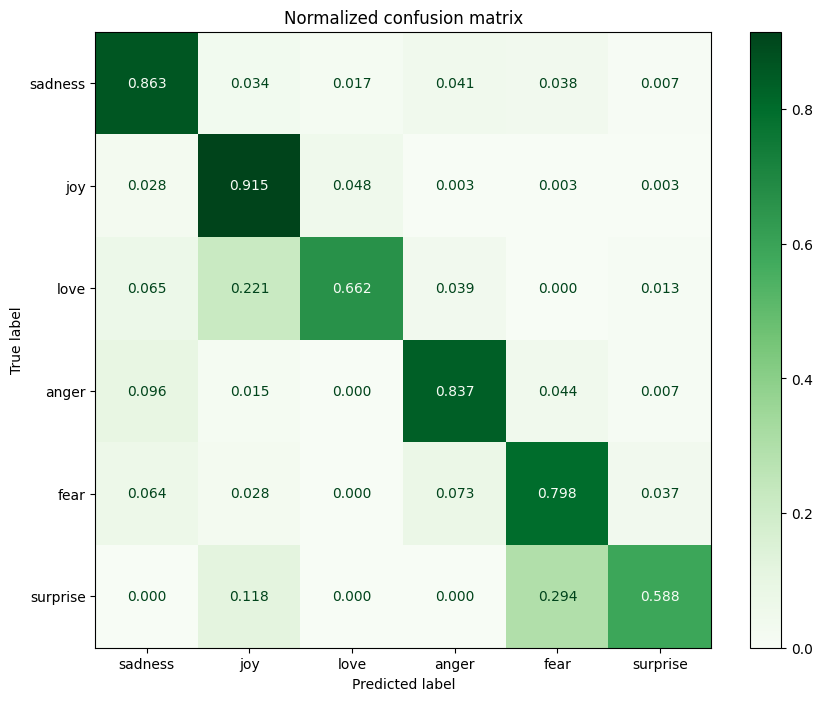

Accuracy: 0.846


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

labels = model.config.id2label.values()
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Greens", values_format=".3f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(true_labels, predictions, labels)
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')


## 2. LSTM

### Make vocab and dataloader

In [3]:
exec(open("01-utilities.py").read())
exec(open("05-utilities.py").read())


In [4]:
ds = {'train': [], 'validation': [], 'test': []}

ra.seed(42)
for split in ["train","test","validation"]:
    for i in range(len(data[split])):
        for s in sentokenize(data[split][i]['text'].lower()):
            p_fold = ra.random()
            if p_fold <= 4/6:
                fold = 'train'
            elif p_fold <= 5/6:
                fold = 'validation'
            else:
                fold = 'test'
            ds[fold].append({'tokens': s+['<eos>'],"label": data[split][i]['label']})

ra.seed(42)
ds['train'] = ra.choices(ds['train'], k=1000)
ds['test'] = ra.choices(ds['train'], k=1000)
ds['validation'] = ra.choices(ds['train'], k=1000)

LSTM_vocab = Vocab()
LSTM_vocab.train(ds['train'])
len(LSTM_vocab._word2idx.keys()), len(ds['train'])


(3120, 1000)

In [5]:
#check
LSTM_vocab._word2idx.keys()


dict_keys(['__UNK__', '', 'i', ' ', 'feel', 'it', 's', 'a', 'bit', 'of', 'from', 'how', 'was', 'dressing', 'in', 'summer', 'with', 'mostly', 'jeremy', 'scott', 'murua', 'amp', 'glad', 'news', '<eos>', 'overhear', 'the', 'victory', 'tune', 'on', 'some', 'geeks', 'ringtone', 'triumphant', 'so', 'rich', 'when', 'pass', 'by', 'you', 'see', 'penny', 'have', 'been', 'procrastinator', 'endless', 'potential', 'and', 'passion', 'inside', 'yet', 'im', 'stuck', 'cage', 'my', 'own', 'soul', 'unresolved', 'feelings', 'hurt', 'resentment', 'that', 'hold', 'has', 'built', 'up', 'even', 'do', 'try', 'to', 'build', 'myself', 'back', 'again', 'hate', 'not', 'feeling', 'useful', 'india', 'lost', 'benson', 'hedges', 'cricket', 'trophy', 'like', 'boring', 'blogger', 'lately', 'really', 'for', 'these', 'innocent', 'kids', 'because', 'only', 'are', 'they', 'taught', 'unconscious', 'racism', 'but', 'then', 'overt', 'no', 'choice', 'follow', 'often', 'an', 'extremely', 'clever', 'talented', 'people', 'love', '

In [5]:
class LSTM_DataLoader(torch.utils.data.Dataset):

  def __init__(self, ds_split, vocab, pad_length = "max"):
    
    self._vocab = vocab
    self._raw = ds_split

    if pad_length=="max":
      self.pad_length = max([len(r['tokens']) for r in self._raw])
    else:
      self.pad_length = pad_length

    self._x_tok = []
    self._y_tok = []

    for r in tqdm(self._raw):
      self._featurize(r)

  def __len__(self):
    return len(self._x_tok)

  def __getitem__(self, item):
    return {'x_tok': self._x_tok[item],
            'y_tok': self._y_tok[item]} 

  def _featurize(self, sample):
    num_tok = len(sample['tokens'])
    for i in range(int(num_tok/self.pad_length)):
        toks = sample['tokens'][i*self.pad_length:(i+1)*self.pad_length]
        self._x_tok.append(torch.LongTensor([self._vocab.encode(t.lower()) 
                                             for t in toks][:-1]))
        self._y_tok.append(sample['label'])
    num_remaining = num_tok % self.pad_length
    if num_remaining:
        to_pad = self.pad_length - num_remaining
        padding = [self._vocab.encode('__UNK__')]*to_pad if to_pad else []
        toks = sample['tokens'][-num_remaining:]
        assert(len(toks) + to_pad == self.pad_length)
        self._x_tok.append(torch.LongTensor([self._vocab.encode(t.lower()) 
                                            for t in toks][:-1]+padding))
        self._y_tok.append(sample['label'])


In [6]:
LSTM_train_loader = LSTM_DataLoader(ds['train'], LSTM_vocab)
LSTM_val_loader = LSTM_DataLoader(ds['validation'], LSTM_vocab)
LSTM_test_loader = LSTM_DataLoader(ds['test'], LSTM_vocab)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
# check
len(LSTM_train_loader._x_tok), LSTM_train_loader[75]


(1000,
 {'x_tok': tensor([  2,   3, 208,   3,   9,   3,  54,   3, 579,   3, 134,   3,   9,   3,
            7,   3, 580,   3, 581,   3, 221,   3,   7,   3, 582,   3,  69,   3,
          583,   3,  76,   3, 584,   3, 121,   3,  96,   3, 585,   3,  26,   3,
           23,   3,  47,   3,  16,   3, 164,   3, 586,   3,   9,   3,  26,   3,
          587,   3, 588,   3, 340,   3, 341,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0]),
  'y_tok': 0})

In [9]:
len(ds['train'][75]['tokens']),ds['train'][75]['label']


(64, 0)

### Word vectors

In [7]:

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

model = api.load("glove-wiki-gigaword-50")


In [8]:
torch.manual_seed(42)

vocab_size = len(LSTM_vocab._word2idx)
vocab_dim = 50  # the size of our pre-trained word vectors

# initialize our word vectors!
LSTM_wvs = torch.zeros(vocab_size, vocab_dim)

for ix in range(vocab_size):
  word = LSTM_vocab.decode(ix)
  if word in model:
    LSTM_wvs[ix, :] = torch.tensor(model[word])
  else:
    LSTM_wvs[ix, :] = torch.randn(vocab_dim)

LSTM_wvs.shape, LSTM_wvs


(torch.Size([3120, 50]),
 tensor([[ 1.9269,  1.4873,  0.9007,  ...,  1.3835, -1.2024,  0.7078],
         [ 2.2181,  0.5232,  0.3466,  ...,  0.5069, -0.4752, -0.4920],
         [ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         ...,
         [ 0.8106, -0.5419,  0.1878,  ..., -0.9614,  0.0169, -1.0266],
         [ 0.4760,  0.8361, -1.1790,  ..., -0.7668, -0.4678, -0.1378],
         [ 0.3964,  1.2262, -0.6604,  ..., -0.3464, -0.6066, -0.4939]]))

### Define LSTM network

In [9]:
class LSTM_LM(nn.Module):

    def __init__(self, in_dim, hidden_dim, lstm_layers, word_vectors, seq_length, output_size=6,
                 dropout=0.05, bidirectional = True):
        super(LSTM_LM, self).__init__()

        self.hidden_dim = hidden_dim  
        self.lstm_layers = lstm_layers 
        self.output_size = output_size 
        self.seq_length = seq_length

        self._embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)      
        self._drop = nn.Dropout(dropout)

        self._lstm = nn.LSTM(in_dim, hidden_dim, num_layers = lstm_layers, dropout = dropout, 
                             bidirectional = bidirectional, batch_first=True)
        self._ReLU = nn.ReLU()
        self._pred = nn.Linear((2 if bidirectional else 1)*hidden_dim*seq_length, output_size) 

    def forward(self, x):
        e = self._drop(self._embed(x))                                      # B, 117, 50 
        z, (hn, cn) = self._lstm(e)                                         # B, 117, 400
        z_drop = self._ReLU(torch.flatten(self._drop(z), start_dim = 1))    # B, 46800    
        s = self._pred(z_drop)                                              # B, 6 
        s = s.view(-1, self.output_size)
        
        return s, (hn, cn)

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.lstm_layers, batch_size, self.hidden_dim)


https://mccormickml.com/2019/09/19/XLNet-fine-tuning/

### Fine-tune

In [36]:
hidden_dim = 200
lstm_layers = 2
seq_length = 117
LSTM_LM_net = LSTM_LM(LSTM_wvs.shape[1], hidden_dim, 
                             lstm_layers, LSTM_wvs, seq_length)

device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")
#device = "cpu"
LSTM_LM_net.to(device) 


LSTM_LM(
  (_embed): Embedding(3120, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_lstm): LSTM(50, 200, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (_ReLU): ReLU()
  (_pred): Linear(in_features=46800, out_features=6, bias=True)
)

In [11]:
def train_lm(model, train_data, val_data, max_epoch=200,
             batch_size=16, lr=0.01, mu=0.25, device='mps'):

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.functional.cross_entropy

    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    epoch = 0
    model.train()
    train_loss = 0
    best_val_loss = None

    while epoch < max_epoch:
        
        print(f'Start epoch {epoch + 1}')
        for step, batch in enumerate(train_loader):
            
            model.zero_grad()
            y_preds, h = model((batch['x_tok']).to(device))
            targets = batch['y_tok'].view(-1).to(device)
            loss = loss_fn(input=y_preds, target=targets, reduction='sum')
            train_loss += loss.cpu().item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), mu)
            opt.step()
            

        print(f'Total epoch loss: {train_loss:.2f} (Avg. {train_loss / (len(train_loader)*(epoch+1)):.6f})')    
        
        model.eval()
        val_loss = 0
        for batch in val_loader:
            y_preds, h = model((batch['x_tok']).to(device))
            targets = batch['y_tok'].view(-1).to(device)
            val_loss += loss_fn(input=y_preds, target=targets, reduction='sum').cpu().item()

        print(f'Total validation loss: {val_loss:.2f} (Avg. {val_loss / (len(val_loader)*(epoch+1)):.6f})')
        
        if not best_val_loss:
            best_val_loss = val_loss
        elif val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            print('No improvement! Early stopping')
            break
        
        epoch += 1
        print()

    return model


In [12]:
batch_size = 16
lr=4e-5
mu = 0.25

LSTM_LM_net_trained = train_lm(LSTM_LM_net, LSTM_train_loader, LSTM_val_loader, batch_size=batch_size, lr=lr, mu=mu)


Start epoch 1
Total epoch loss: 1605.31 (Avg. 25.481150)
Total validation loss: 1585.99 (Avg. 25.174402)

Start epoch 2
Total epoch loss: 3177.46 (Avg. 25.217948)
Total validation loss: 1541.60 (Avg. 12.234933)

Start epoch 3
Total epoch loss: 4714.22 (Avg. 24.942940)
Total validation loss: 1505.55 (Avg. 7.965874)

Start epoch 4
Total epoch loss: 6219.30 (Avg. 24.679750)
Total validation loss: 1475.84 (Avg. 5.856490)

Start epoch 5
Total epoch loss: 7674.50 (Avg. 24.363504)
Total validation loss: 1385.02 (Avg. 4.396887)

Start epoch 6
Total epoch loss: 9065.84 (Avg. 23.983713)
Total validation loss: 1339.10 (Avg. 3.542596)

Start epoch 7
Total epoch loss: 10378.30 (Avg. 23.533557)
Total validation loss: 1277.32 (Avg. 2.896406)

Start epoch 8
Total epoch loss: 11597.33 (Avg. 23.010570)
Total validation loss: 1182.34 (Avg. 2.345920)

Start epoch 9
Total epoch loss: 12773.06 (Avg. 22.527446)
Total validation loss: 1113.70 (Avg. 1.964203)

Start epoch 10
Total epoch loss: 13908.61 (Avg. 22

In [13]:
torch.save(LSTM_LM_net_trained, 'fine-tuned-LSTM.pt')


### Validation

In [14]:
model = torch.load("/Users/ks4254/Library/Mobile Documents/com~apple~CloudDocs/DSCI691_NLP/project/fine-tuned-LSTM.pt")


In [15]:
# A8:Function(4/4)

def eval_simple(net, val_loader, batch_size, device="mps"):
    # initialize our batch loader
    torch.manual_seed(42)
    val_loader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=True)

    # disable training... we're in the eval function!
    net.eval()
    preds = []
    golds = []
    
    for step, batch in enumerate(val_loader):

        y_gold = batch['y_tok']
        y_preds, h = model((batch['x_tok']).to(device))
        y_preds = torch.argmax(torch.softmax(y_preds, dim=1).to('cpu'),dim=1).detach().numpy()
        preds.extend(y_preds) 
        golds.extend(y_gold)
               
    return classification_report(golds, preds, output_dict=True)


In [16]:
classification_report_ = eval_simple(net=model, val_loader=LSTM_val_loader, batch_size=16)


In [28]:
report_df = pd.DataFrame(classification_report_).transpose()
report_df.index = ["Sadness", "Joy", "Love", "Anger" ,"Fear", "Surprise", "Accuracy", "Macor Avg", "Wt Avg"]


In [34]:
report_df


,precision,recall,f1-score,support
Sadness,0.499006,0.919414,0.646907,273.000
Joy,0.806061,0.760000,0.782353,350.000
Love,1.000000,0.123288,0.219512,73.000
Anger,0.833333,0.384615,0.526316,156.000
Fear,0.666667,0.452174,0.538860,115.000
Surprise,1.000000,0.242424,0.390244,33.000
Accuracy,0.646000,0.646000,0.646000,0.646
Macor Avg,0.800844,0.480319,0.517365,1000.000
Wt Avg,0.731017,0.646000,0.623406,1000.000
